In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask.array as da
import anndata
import scanpy as sc

from os.path import join

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read data

In [2]:
PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

In [3]:
ddf = dd.read_parquet(join(PATH, 'train'), split_row_groups=True)
cell_type_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/cell_type.parquet'))

In [6]:
def get_count_matrix_and_obs(ddf):
    obs = ddf[['cell_type', 'tech_sample', 'assay', 'dataset_id', 'tissue']].compute()
    x = (
        ddf['X']
        .map_partitions(
            lambda xx: pd.DataFrame(np.vstack(xx.tolist())), 
            meta={col: 'f4' for col in range(19331)}
        )
        .to_dask_array(lengths=[1024] * ddf.npartitions)
    )
    obs = ddf[['cell_type', 'tech_sample', 'assay', 'dataset_id', 'tissue']].compute()

    return x, obs

In [7]:
x, obs = get_count_matrix_and_obs(ddf)

In [8]:
x

dask.array<values, shape=(15240192, 19331), dtype=float32, chunksize=(1024, 19331), chunktype=numpy.ndarray>

In [9]:
n_samples = 500_000

rng = np.random.default_rng(seed=1)
sampling_probs = 1. / pd.Series(obs.cell_type).replace(obs.cell_type.value_counts().to_dict())
sampling_probs = sampling_probs / sampling_probs.sum()
idx_subsample = np.sort(rng.choice(np.arange(len(obs)), size=n_samples, replace=False, p=sampling_probs))

# Compute data augmentation

In [10]:
max_augmentations = 300

In [11]:
x_dense = x[idx_subsample].compute()
tech_samples = obs.iloc[idx_subsample].tech_sample.to_numpy()
cell_types = obs.iloc[idx_subsample].cell_type.to_numpy()

In [12]:
from typing import List

from numba import njit, prange


@njit
def np_apply_along_axis(func1d, axis, arr):
    assert arr.ndim == 2
    assert axis in [0, 1]
    if axis == 0:
        result = np.empty(arr.shape[1])
        for i in range(len(result)):
            result[i] = func1d(arr[:, i])
    else:
        result = np.empty(arr.shape[0])
        for i in range(len(result)):
            result[i] = func1d(arr[i, :])
    return result


@njit
def np_mean(array, axis):
    return np_apply_along_axis(np.mean, axis, array)


@njit(parallel=True)
def calculate_means(x_gene: np.ndarray, tech_sample: np.ndarray, cell_type: np.ndarray):
    n_cell_type = np.max(cell_type) + 1
    means_grouped_by_cell_type = [
        np.zeros((len(np.unique(tech_sample[cell_type == i])), x_gene.shape[1]), dtype='f4')
        for i in range(n_cell_type)
    ]

    for i in prange(n_cell_type):
        for ix_sample, sample in enumerate(np.unique(tech_sample[cell_type == i])):
            means_grouped_by_cell_type[i][ix_sample, :] = np_mean(x_gene[(cell_type == i) & (tech_sample == sample), :], axis=0)

    return means_grouped_by_cell_type


@njit
def get_combinations(n, max_combinations):
    n_combinations = (n * (n - 1)) // 2 - 1
    if max_combinations < 0:
        max_combinations = n_combinations
    combinations = []

    for i in range(n):
        for j in range(i+1, n):
            combinations.append([i, j])

    combinations = np.array(combinations)
    idx_sample = np.random.choice(combinations.shape[0], min([n_combinations, max_combinations]), replace=False)

    return combinations[idx_sample, :]


def calculate_data_augmentation(mean_vecs: List[np.ndarray], max_augmentations: int = 50):
    n_means = [mean_vec.shape[0] for mean_vec in mean_vecs]
    n_genes = mean_vecs[0].shape[1]

    data_augmentation = [np.zeros((min([(n * (n - 1)) // 2 - 1, max_augmentations]), n_genes)) for n in n_means]

    for i in prange(len(n_means)):
        means = mean_vecs[i]
        for ix, (j, k) in enumerate(get_combinations(n_means[i], max_augmentations)):
            data_augmentation[i][ix, :] = means[j, :] - means[k, :]

    return data_augmentation



In [79]:
mean_vectors = calculate_means(x_dense, tech_samples, cell_types)
augmentations = calculate_data_augmentation(mean_vectors, max_augmentations)
augmentations_concat = np.concatenate(augmentations, axis=0)

In [83]:
(np.abs(augmentations_concat) > 0.25).mean()

0.12980969992044142

In [84]:
np.quantile(augmentations_concat, 0.995)

1.4127073138952255

In [85]:
(x_dense > 0.0).mean()

0.10096494325177177

In [91]:
augmentations_concat[np.abs(augmentations_concat) <= 0.25] = 0.

In [92]:
augmentations_concat = np.clip(augmentations_concat, -1.5, 1.5)

In [94]:
(np.abs(augmentations_concat) > 0.0).mean()

0.12980969992044142

# Select data augmentations to use

In [95]:
import anndata
import scanpy as sc

augmentations_adata = anndata.AnnData(X=augmentations_concat)

In [96]:
sc.pp.pca(augmentations_adata)

In [97]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=50, n_init='auto').fit(augmentations_concat)
augmentations_adata.obs['kmeans_cluster'] = kmeans.labels_
augmentations_adata.obs['kmeans_cluster'] = augmentations_adata.obs['kmeans_cluster'].astype('category')

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


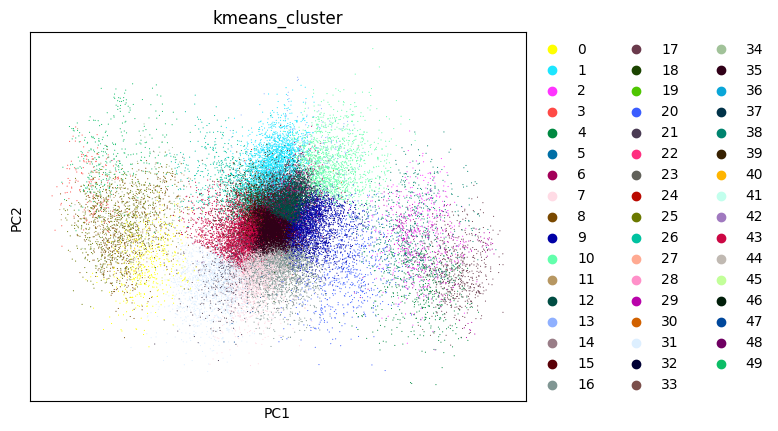

In [98]:
sc.pl.pca(augmentations_adata, color='kmeans_cluster')

In [101]:
SAMPLE_SIZE = 5000
WEIGHTED_SAMPLING = False

rng = np.random.default_rng(seed=1)


cluster_size = pd.Series(kmeans.labels_).value_counts()
clusters_to_use = cluster_size[cluster_size > 2000].index.tolist()
augmentations_to_use = augmentations_concat[pd.Series(kmeans.labels_).isin(clusters_to_use)]


if WEIGHTED_SAMPLING:
    sampling_probs = 1. / pd.Series(kmeans.labels_).replace(pd.Series(kmeans.labels_).value_counts().to_dict())
    sampling_probs = sampling_probs / sampling_probs.sum()
    augmentations = augmentations_to_use[
        rng.choice(np.arange(augmentations_to_use.shape[0]), size=SAMPLE_SIZE, replace=False, p=sampling_probs), :
    ]
else:
    augmentations = augmentations_to_use[
        rng.choice(np.arange(augmentations_to_use.shape[0]), size=SAMPLE_SIZE, replace=False), :
    ]


# Visualize augmentations

In [102]:
rng = np.random.default_rng(seed=1)

samples_plot = rng.choice(np.arange(n_samples), replace=False, size=100_000)

In [103]:
cell_type_mapping = pd.read_parquet(join(PATH, 'categorical_lookup/cell_type.parquet'))

## Unaugmented data

In [55]:
adata = anndata.AnnData(
    X=x_dense[samples_plot, :], 
    obs=pd.DataFrame({
        'cell_type': cell_type_mapping.iloc[obs.iloc[idx_subsample].iloc[samples_plot]['cell_type']].to_numpy().flatten()
    })
)
sc.pp.pca(adata)
sc.tl.tsne(adata)

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


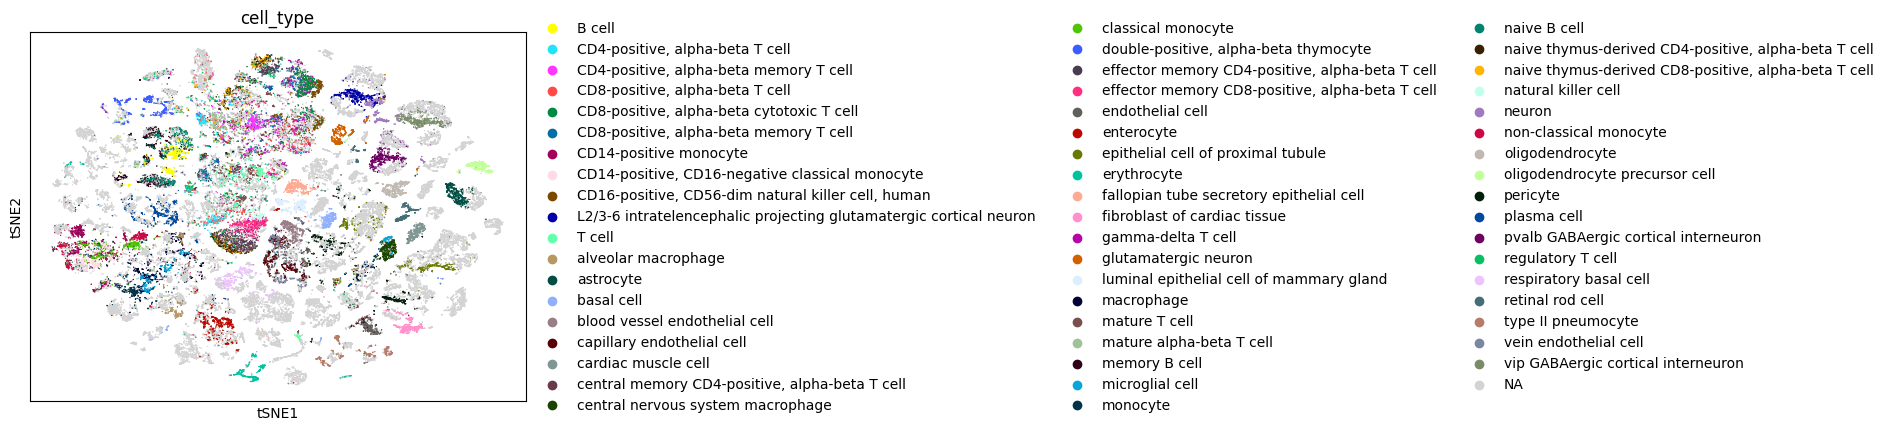

In [56]:
cell_freq = obs.cell_type.value_counts()
cells_to_plot = cell_type_mapping.iloc[cell_freq[cell_freq > 60000].index.tolist()].label.tolist()
adata_plot = adata.copy()
adata_plot.obs['cell_type'] = adata_plot.obs.cell_type.mask(~adata_plot.obs.cell_type.isin(cells_to_plot))
sc.pl.tsne(adata_plot, color='cell_type', s=3)

## Augmented data

In [104]:
x_augment = np.clip(
    x_dense[samples_plot, :] + 
    (np.random.choice([-1., 1.], size=(len(samples_plot), 1)) * 
    augmentations[np.random.choice(np.arange(augmentations.shape[0]), size=len(samples_plot))]),
    a_min=0.,
    a_max=9.
)
adata_augment = anndata.AnnData(
    X=x_augment, 
    obs=pd.DataFrame({
        'cell_type': cell_type_mapping.iloc[obs.iloc[idx_subsample].iloc[samples_plot]['cell_type']].to_numpy().flatten()
    })
)
sc.pp.pca(adata_augment)
sc.tl.tsne(adata_augment)

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


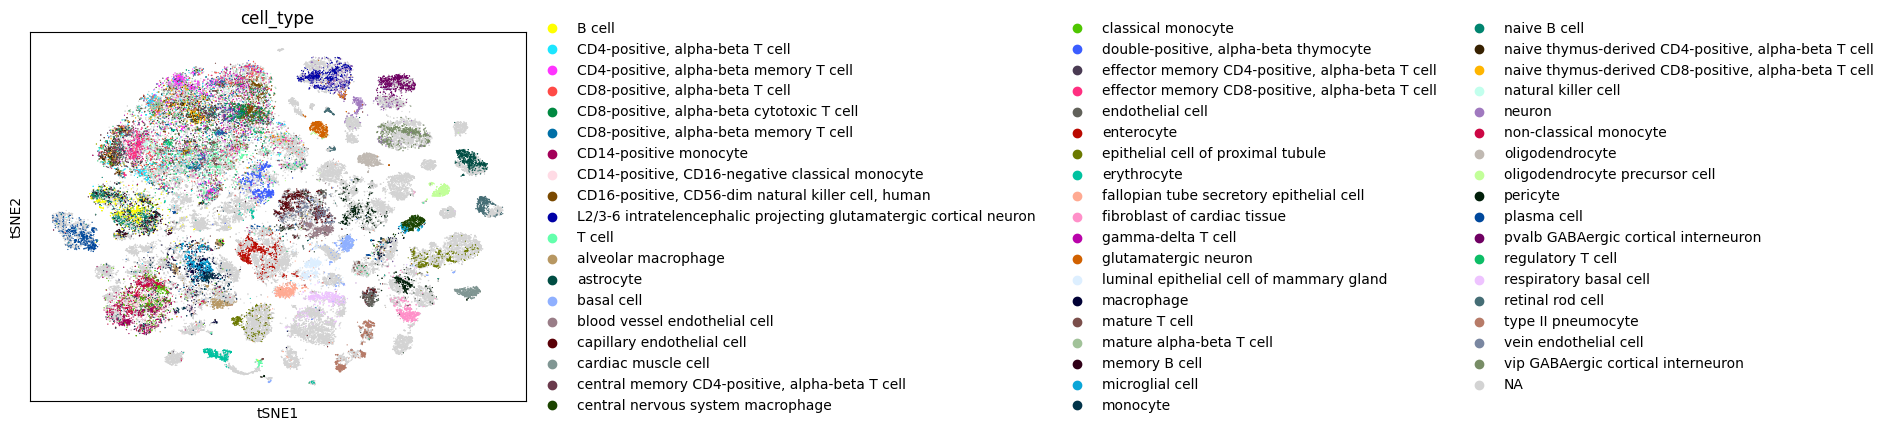

In [105]:
adata_plot = adata_augment.copy()
adata_plot.obs['cell_type'] = adata_plot.obs.cell_type.mask(~adata_plot.obs.cell_type.isin(cells_to_plot))
sc.pl.tsne(adata_plot, color='cell_type', s=3)

In [108]:
(adata_augment.X > 0.).mean()

0.14291968030624386

In [109]:
(adata.X > 0.).mean()

0.10122971289638405

# Save data augmentations

In [110]:
with open(join(PATH, 'augmentations.npy'), 'wb') as f:
    np.save(f, augmentations)

# Check out augmentations

In [111]:
print(f'size augmentation file: {augmentations.size * 8 // 1000**2} MB')

size augmentation file: 773 MB


In [114]:
(np.abs(augmentations) > 0.).mean()

0.11431875226320418

In [113]:
(x_dense > 0.).mean()

0.10096494325177177

In [115]:
augmentations.shape

(5000, 19331)